In [2]:
from scipy.spatial import distance as dist  # provides functions for computing distances
from scipy.spatial import Voronoi
from shapely.geometry import Polygon
import pickle
from collections import OrderedDict 
import numpy as np  # y'all already know
from __future__ import print_function
import cv2 as cv
import argparse
import random as rng
import matplotlib.pyplot as plt

In [3]:
def getHeights(filename,videoNumber):
    #vids are ordered chronologically
    colToUse = {1:(1,2),2:(4,5),3:(7,8),4:(10,11)}
    
    data = np.genfromtxt(filename, delimiter = ",",skip_header = 1,usecols = colToUse[videoNumber])
    altitude = data[:,0]
    altitude = altitude-altitude[0]
    isVideo = data[:,1]
    altitude = altitude[~np.isnan(altitude)]
    altitude = altitude*0.3048
    isVideo = isVideo[0:np.size(altitude)]
    if not (videoNumber==1):
        minIndex = np.min(np.where(isVideo==1))
        altitude = altitude[minIndex:]
        isVideo = isVideo[minIndex:]
    return altitude,isVideo

def pixelMeterRatio(height,frameShape):
    #outputs a number in meters/pixels
    
    #focal length 35mm
    #
    sensorWidth = np.sqrt(7.65**2-4.55**2)/1000
    sensorHeight = 4.55/1000
    #Horiz GSD
    #(height * Sensor Width) / (Focal Length * frameWidth)
    #Vertical GSD:
    #(height * Sensor Height) / (Focal Length * FrameHeight)
    
    horizGSD = (height*sensorWidth)/(0.035*frameShape[1])
    VerticalGSD = (height*sensorHeight)/(0.035*frameShape[0])
    
#     initialAltitude = 6.889764004*0.3048
#   initialAltitude/(height*474)
    return (horizGSD,VerticalGSD)

In [17]:
def get_Displacements(tArr,Xarr,Yarr,heights,frameShape):

    Displacements = np.zeros((np.size(tArr),4))
    
    hIndex = 0
    for t in range(np.size(tArr)):
            
        if t == 0:
            continue
        else:
            if t%3==0:
                hIndex+=1
            h = heights[hIndex]
            conversion = pixelMeterRatio(h,frameShape)
                
            x0,y0 = Xarr[t-1],Yarr[t-1]
            x1,y1 = Xarr[t],Yarr[t]
                
                
                
#                 r = np.sqrt((x0-medianX)**2 + (y0-medianY)**2)
                
            dt = 0.03
            u_x = conversion[0]*(x1 - x0)/dt
            u_y = conversion[1]*(y1 - y0)/dt
                
                
            u_mag = np.sqrt(u_x**2 + u_y**2)
#                 apparentSize = u_mag
#                 if (apparentSize == 0):
#                     new_items = np.array([dictionary[k][t, 0], u_x, u_y, u_mag])
#                     continue
#                 actualSize = np.sqrt(r**2+h**2)*apparentSize/(h*np.cos(np.atan(r/h)))
#                 u_x = u_x*actualSize/apparentSize
#                 u_y = u_y*actualSize/apparentSize
#                 u_mag = actualSize
                
                
            Displacements[t,:] = np.array([tArr[t], u_x, u_y, u_mag])

    
    return Displacements

In [18]:
def datax(filename):
    datax = np.genfromtxt(filename, delimiter = ",",skip_header = 2)
    X = []
    Y = []
    t = []
    for row in datax:
        t.append(row[0])
        X.append(row[1])
        Y.append(row[2])
    return np.array(t),np.array(X),np.array(Y)


In [33]:
fname = "altitudeVideo.csv"
altitude,isVideo = getHeights(fname,4)


clipNumToFrameStartVideoNum = {1:(64*30,4),2:(125*30,4),3:(298*30,4),
                               4:(389*30,4),5:(409*30,4),6:(438*30,4),
                               8:(496*30,4),9:(520*30,4),10:(535*30,4),
                               11:(555*30,4),12:(624*30,4)}
frameShape = (1920,1080)

allDisplacements = []

for counter in range(1,13):
    if counter==7:
        continue

    fname = "/Users/mikey/Summer 2025/MatlabGitVTP/Dog Motion Csvs/13_02_clip"+str(counter)+"_dog.csv"
    tArr,Xarr,Yarr = datax(fname)
    frameStart = clipNumToFrameStartVideoNum[counter][0]
    vidNum = clipNumToFrameStartVideoNum[counter][1]
    timesinceVidStart = int(np.floor(frameStart/3))
    heights = altitude[timesinceVidStart:]
    
    U = get_Displacements(tArr,Xarr,Yarr,heights,frameShape)
    allDisplacements.append(U)

In [34]:
vAvgs = []
vStds = []
vMax = []
for disp in allDisplacements:
    tempArr = disp[:,3]
#     q1 = np.percentile(tempArr, 25)
#     q3 = np.percentile(tempArr, 75)
#     iqr = q3 - q1
#     h = (iqr*np.power(np.size(tempArr),-1/3))
#     if h!=0:
#         numBins = int(np.round((np.max(tempArr)-np.min(tempArr))/h))
#     else:
#         numBins=10
    m = np.mean(tempArr)
    s = np.std(tempArr)
    vAvgs.append(m)
    vStds.append(s)
    vMax.append(m+3*s)
vAvgs = np.array(vAvgs)
vStds = np.array(vStds)
vMax = np.array(vMax)

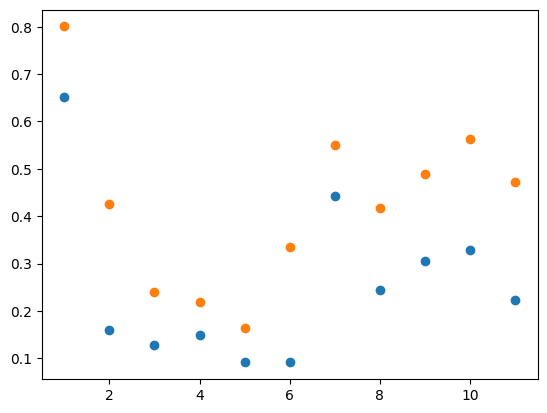

In [35]:
x = np.array([1,2,3,4,5,6,7,8,9,10,11])
plt.scatter(x,vAvgs)
plt.scatter(x,vStds)
plt.show()

(array([3., 1., 3., 1., 2., 0., 1.]),
 array([0.58224232, 0.93541059, 1.28857886, 1.64174713, 1.9949154 ,
        2.34808367, 2.70125194, 3.05442021]),
 <BarContainer object of 7 artists>)

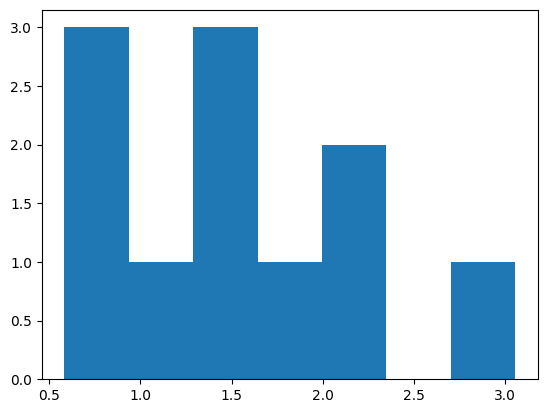

In [36]:
plt.hist(vMax,bins=7)

In [37]:
print(np.mean(vMax))

1.5307740677166393
